This is an updated version of an [older post](https://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html).


# Motivation

A frequent desire when working with chemical fingerprints is to see what the indvidual bits actually "mean". For most of the fingerprinting algorithms in the RDKit this question only means something in the context of a molecule, so there have been a number of code samples floating around (including in the RDKit documentation) allowing the user to show the atoms/bonds in a molecule that are responsible for setting a particular bit. In the 2018.09 release we made this easier and added a few functions to the `rdkit.Chem.Draw` package that allow direct visualization of the atoms and bonds from a molecule that set bits from Morgan and RDKit fingerprints.

This notebook shows how to use this functionality. Note that since this is new code, it will only work in RDKit versions 2018.09 and later.

The code that is used for this is derived from the bit rendering code that Nadine Schneider wrote for [CheTo](https://github.com/rdkit/CheTo).

Start by importing the required packages:

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

We'll use epinephrine as the demo molecule:

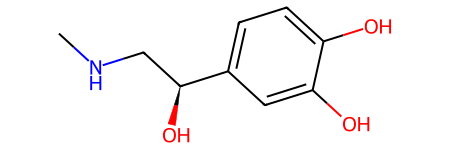

In [2]:
epinephrine = Chem.MolFromSmiles('CNC[C@H](O)c1ccc(O)c(O)c1')
epinephrine

## Looking at Morgan bits

Generate a Morgan fingerprint and save information about the bits that are set using the `bitInfo` argument:

In [4]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()

fp = fpg.GetFingerprint(epinephrine,additionalOutput=ao)
# show 10 of the set bits:
list(fp.GetOnBits())[:10]

[1, 80, 227, 315, 589, 606, 632, 807, 875, 1057]

In its simplest form, the new code lets you display the atomic environment that sets a particular bit. Here we will look at bit 589:

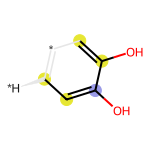

In [5]:
Draw.DrawMorganBit(epinephrine,589,ao.GetBitInfoMap())

There's also a function, `DrawMorganBits()`, for drawing multiple bits at once (thanks to Pat Walters for suggesting this one):

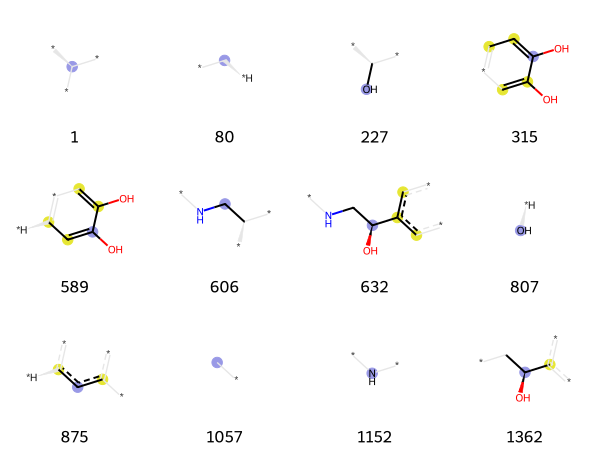

In [6]:
tpls = [(epinephrine,x,ao.GetBitInfoMap()) for x in fp.GetOnBits()]
Draw.DrawMorganBits(tpls[:12],molsPerRow=4,legends=[str(x) for x in fp.GetOnBits()][:12])

Some notes about the rendering here:

  - The molecule fragment is drawn with the atoms in the same positions as in the original molecule.
  - The central atom is highlighted in blue.
  - Aromatic atoms are highlighted in yellow
  - Aliphatic ring atoms (none present here) are highlighted in dark gray
  - Atoms/bonds that are drawn in light gray indicate pieces of the structure that influence the atoms' connectivity invariants but that are not directly part of the fingerprint.

We can also take advantage of the interactivity features of the Jupyter notebook and create a widget allowing is to browse through the bits. Note that this does not work in the blog post or the github view of the notebook; you will need to download the notebook and try it yourself to see this interactivity.

In [7]:
from ipywidgets import interact,fixed,IntSlider
def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol,bid,bitInfo)))


In [ ]:
bi = ao.GetBitInfoMap()
interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(epinephrine),bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit));

Here's a GIF showing what the output of the above cell looks like:

![animation showng interaction](./images/blog/updated-bit-rendering-movie1.gif)

## Looking at RDKit bits

We can do the same thing with RDKit bits:

In [9]:
fpg = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()

rdkfp = fpg.GetFingerprint(epinephrine,additionalOutput=ao)

# show 10 of the set bits:
list(rdkfp.GetOnBits())[:10]

[93, 103, 112, 122, 148, 149, 161, 166, 194, 208]

In [11]:
print(rdkfp.GetNumOnBits(),len(ao.GetBitPaths()))

128 128


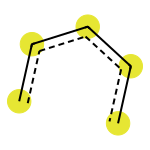

In [10]:
Draw.DrawRDKitBit(epinephrine,103,ao.GetBitPaths())

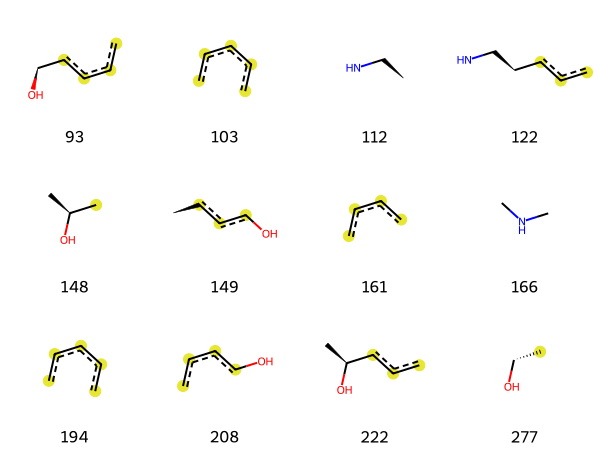

In [12]:
rdkbi = ao.GetBitPaths()
tpls = [(epinephrine,x,rdkbi) for x in rdkbi]
Draw.DrawRDKitBits(tpls[:12],molsPerRow=4,legends=[str(x) for x in rdkbi][:12])

Some notes about the rendering here:

  - The molecule fragment is drawn with the atoms in the same positions as in the original molecule.
  - All bonds that are drawn are part of the bit.
  - Aromatic atoms are highlighted in yellow
  - By default there is no additional highlighting for aliphatic ring atoms, but this can be changed using the `nonAromaticColor` optional argument.

We can, of course, use the same jupyter interactivity features here as we did for the Morgan fingerprint:

In [ ]:
interact(renderFpBit, bitIdx=list(rdkbi.keys()),mol=fixed(epinephrine),bitInfo=fixed(rdkbi),fn=fixed(Draw.DrawRDKitBit));

Here's a GIF showing what the output of the above cell looks like:

![animation showng interaction](./images/blog/updated-bit-rendering-movie2.gif)